In [ ]:
# Install the latest JAXlib version.
!pip install --upgrade -q pip jax jaxlib
# Install Flax at head:
!pip install --upgrade -q git+https://github.com/google/flax.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 21.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
import jax
from typing import Any, Callable, Sequence
from jax import lax, random, numpy as jnp
from flax import linen as nn

In [ ]:
import tensorflow as tf
# Ensure TF does not see GPU and grab all GPU memory.
#tf.config.set_visible_devices([], device_type='GPU')

import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# as_supervised=True gives us the (image, label) as a tuple instead of a dict
data, info = tfds.load(name="mnist",
                       data_dir=data_dir,
                       as_supervised=True,
                       with_info=True)

data_train = data['train']
data_test  = data['test']

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /tmp/tfds/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/tmp/tfds/mnist/3.0.1.incompleteQW1GWM',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

ROWS = 3
COLS = 10

HEIGHT = 28
WIDTH  = 28
CHANNELS = 1
NUM_PIXELS = HEIGHT * WIDTH * CHANNELS
NUM_LABELS = info.features['label'].num_classes

In [ ]:
def preprocess(img, label):
  """Resize and preprocess images."""
  return (tf.cast(img, tf.float32)/255.0), label

In [ ]:
data_train_vis = data_train.map(preprocess)

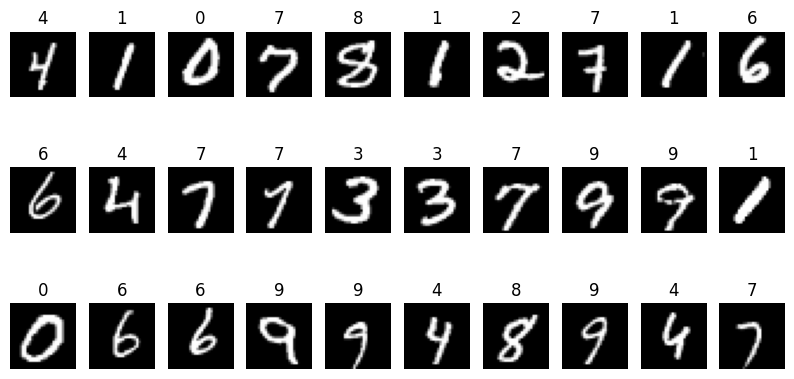

In [ ]:
i = 0
fig, ax = plt.subplots(ROWS, COLS)
for image, label in data_train_vis.take(ROWS*COLS):
    ax[int(i/COLS), i%COLS].axis('off')
    ax[int(i/COLS), i%COLS].set_title(str(label.numpy()))
    ax[int(i/COLS), i%COLS].imshow(np.reshape(image, (28,28)), cmap='gray')
    i += 1

plt.show()

In [ ]:
train_data = tfds.as_numpy(data_train.map(preprocess).batch(32).prefetch(1))
test_data  = tfds.as_numpy(data_test.map(preprocess).batch(32).prefetch(1))

In [ ]:
class MLP(nn.Module):
  """A simple MLP model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=512)(x)
    x = nn.activation.swish(x)
    x = nn.Dense(features=10)(x)
    return x

In [ ]:
model = MLP()

In [ ]:
key1, key2 = random.split(random.PRNGKey(0))
random_flattened_image = random.normal(key1, (28*28*1,))
params = model.init(key2, random_flattened_image) # Initialization call
jax.tree_util.tree_map(lambda x: x.shape, params) # Checking output shapes

FrozenDict({
    params: {
        Dense_0: {
            bias: (512,),
            kernel: (784, 512),
        },
        Dense_1: {
            bias: (10,),
            kernel: (512, 10),
        },
    },
})

In [ ]:
print(model.tabulate(key2, random_flattened_image))


                                 MLP Summary                                 
┏━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module ┃ inputs       ┃ outputs      ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ MLP    │ float32[784] │ float32[10]  │                          │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_0 │ Dense  │ float32[784] │ float32[512] │ bias: float32[512]       │
│         │        │              │              │ kernel: float32[784,512] │
│         │        │              │              │                          │
│         │        │              │              │ 401,920 (1.6 MB)         │
├─────────┼────────┼──────────────┼──────────────┼──────────────────────────┤
│ Dense_1 │ Dense  │ float32[512] │ float32[10]  │ bias: float32[10]        │
│         │        │              │              │ kernel: floa

In [ ]:
jax.devices()

[CpuDevice(id=0)]

In [ ]:
model.apply(params, random_flattened_image)

Array([ 0.43500084,  0.20896661, -0.9779186 ,  0.3447541 ,  0.05475511,
        0.29811084, -0.24472891, -0.30921277,  0.2945502 , -0.34386003],      dtype=float32)

In [ ]:
INIT_LR = 1.0
DECAY_RATE = 0.95
DECAY_STEPS = 5

In [ ]:
def loss(params, images, targets):
  """Categorical cross entropy loss function."""
  logits = model.apply(params, images)    # new
  log_preds = logits - jax.nn.logsumexp(logits)
  return -jnp.mean(targets*log_preds)

In [ ]:
@jax.jit
def update(params, x, y, epoch_number):
  loss_value, grads = jax.value_and_grad(loss)(params, x, y)
  lr = INIT_LR * DECAY_RATE ** (epoch_number / DECAY_STEPS)
  return jax.tree_util.tree_map(    # new, better suited for pytrees
      lambda p, g: p - lr * g, params, grads), loss_value

In [ ]:
num_epochs = 25

In [ ]:
@jax.jit
def batch_accuracy(params, images, targets):
  images = jnp.reshape(images, (len(images), NUM_PIXELS))
  predicted_class = jnp.argmax(model.apply(params, images), axis=1)    # new
  return jnp.mean(predicted_class == targets)

def accuracy(params, data):
  accs = []
  for images, targets in data:
    accs.append(batch_accuracy(params, images, targets))
  return jnp.mean(jnp.array(accs))

import time

for epoch in range(num_epochs):
  start_time = time.time()
  losses = []
  for x, y in train_data:
    x = jnp.reshape(x, (len(x), NUM_PIXELS))
    y = jax.nn.one_hot(y, NUM_LABELS)
    params, loss_value = update(params, x, y, epoch)
    losses.append(loss_value)
  epoch_time = time.time() - start_time

  start_time = time.time()
  train_acc = accuracy(params, train_data)
  test_acc = accuracy(params, test_data)
  eval_time = time.time() - start_time
  print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
  print("Eval in {:0.2f} sec".format(eval_time))
  print("Training set loss {}".format(jnp.mean(jnp.array(losses))))
  print("Training set accuracy {}".format(train_acc))
  print("Test set accuracy {}".format(test_acc))

Epoch 0 in 5.89 sec
Eval in 3.75 sec
Training set loss 0.40118706226348877
Training set accuracy 0.9405333399772644
Test set accuracy 0.9416932463645935
Epoch 1 in 4.43 sec
Eval in 3.06 sec
Training set loss 0.3758145570755005
Training set accuracy 0.957716703414917
Test set accuracy 0.9574680328369141
Epoch 2 in 3.87 sec
Eval in 3.31 sec
Training set loss 0.3697490096092224
Training set accuracy 0.9668000340461731
Test set accuracy 0.9651557207107544
Epoch 3 in 4.40 sec
Eval in 3.06 sec
Training set loss 0.36639681458473206
Training set accuracy 0.9719333648681641
Test set accuracy 0.96875
Epoch 4 in 3.79 sec
Eval in 3.92 sec
Training set loss 0.3641383647918701
Training set accuracy 0.9758833646774292
Test set accuracy 0.9709464907646179
Epoch 5 in 3.79 sec
Eval in 3.05 sec
Training set loss 0.3624792695045471
Training set accuracy 0.97843337059021
Test set accuracy 0.9731429815292358
Epoch 6 in 4.95 sec
Eval in 3.30 sec
Training set loss 0.3611924648284912
Training set accuracy 0.98